In [18]:
import pandas as pd
import numpy as np
#import scikitplot
import random
import seaborn as sns
import keras
import os
import cv2
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Loading Data

In [19]:
data = pd.read_csv(r"C:\Users\dsilv\development\Emotion Detection\data\fer2013.csv")
data.shape

(35887, 3)

In [20]:
data.isnull().sum()


emotion    0
pixels     0
Usage      0
dtype: int64

In [21]:
data.head()


emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

Data pre-processing

In [22]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [23]:
data = data.sample(frac=1)

In [24]:
labels = to_categorical(data[['emotion']], num_classes=7)

In [25]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

In [26]:
pixels = train_pixels.reshape((35887*2304,1))

In [27]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

In [28]:
pixels = train_pixels.reshape((35887, 48, 48,1))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


In [31]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

In [32]:
datagen = ImageDataGenerator(
    width_shift_range=0.05,  # Reduced shift range
    height_shift_range=0.05, # Reduced shift range
    horizontal_flip=True, 
    zoom_range=0.1          # Reduced zoom range
)

valgen = ImageDataGenerator()  # No augmentation for validation data


In [33]:
datagen.fit(X_train)
valgen.fit(X_val)

In [36]:
# No need to call fit() unless using featurewise normalization
# Simply use the generators directly on the data
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = valgen.flow(X_val, y_val, batch_size=32)


CNN Model

In [39]:
from tensorflow.keras.layers import GlobalAveragePooling2D


def cnn_model():
    model = tf.keras.models.Sequential()

    # First convolutional block
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))  # Slightly lower dropout

    # Second convolutional block
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))  # Balanced dropout

    # Third convolutional block
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Fourth convolutional block
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Global Average Pooling
    model.add(GlobalAveragePooling2D())

    # Fully connected layers
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Higher dropout for dense layers
    
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(7, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [40]:
model = cnn_model()

In [41]:
model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           51

 Total params: 490,887 (1.87 MB)

 Trainable params: 489,159 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [45]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.keras',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [46]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=32,   
                    verbose=1,
                    callbacks=checkpointer,
                    validation_data=val_generator)

Epoch 1/30
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1817 - loss: 3.0115
Epoch 1: val_accuracy improved from -inf to 0.25728, saving model to best_model.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 66s 72ms/step - accuracy: 0.1817 - loss: 3.0114 - val_accuracy: 0.2573 - val_loss: 2.4966
Epoch 2/30
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2052 - loss: 2.8042
Epoch 2: val_accuracy improved from 0.25728 to 0.26378, saving model to best_model.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - accuracy: 0.2052 - loss: 2.8042 - val_accuracy: 0.2638 - val_loss: 2.4483
Epoch 3/30
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2196 - loss: 2.6911
Epoch 3: val_accuracy improved from 0.26378 to 0.28266, saving model to best_model.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.2196 - loss: 2.6910 - val_accuracy: 0.2827 - val_loss: 2.3924
Epoch 4/30
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2235 - loss: 2.6153
Epoch 4: val_accuracy improved 

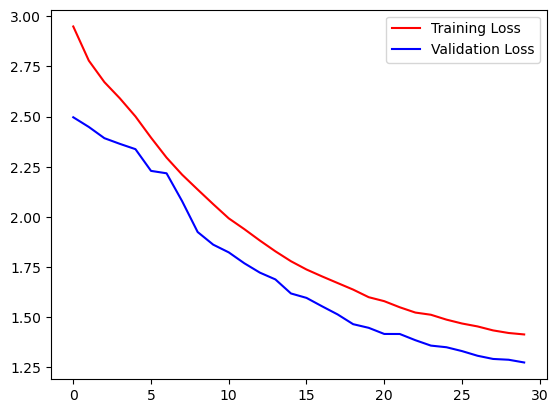

In [47]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

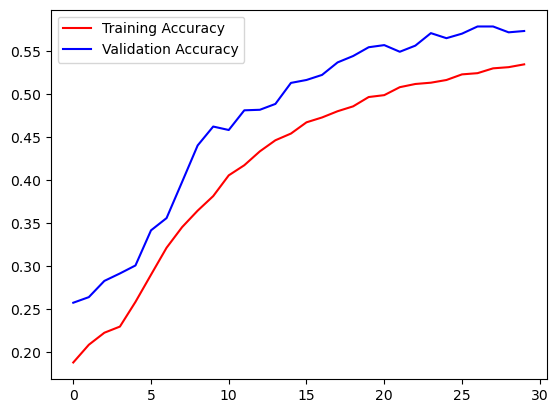

In [48]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [49]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5796 - loss: 1.2970
Test Acc: 0.5781554579734802


In [50]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


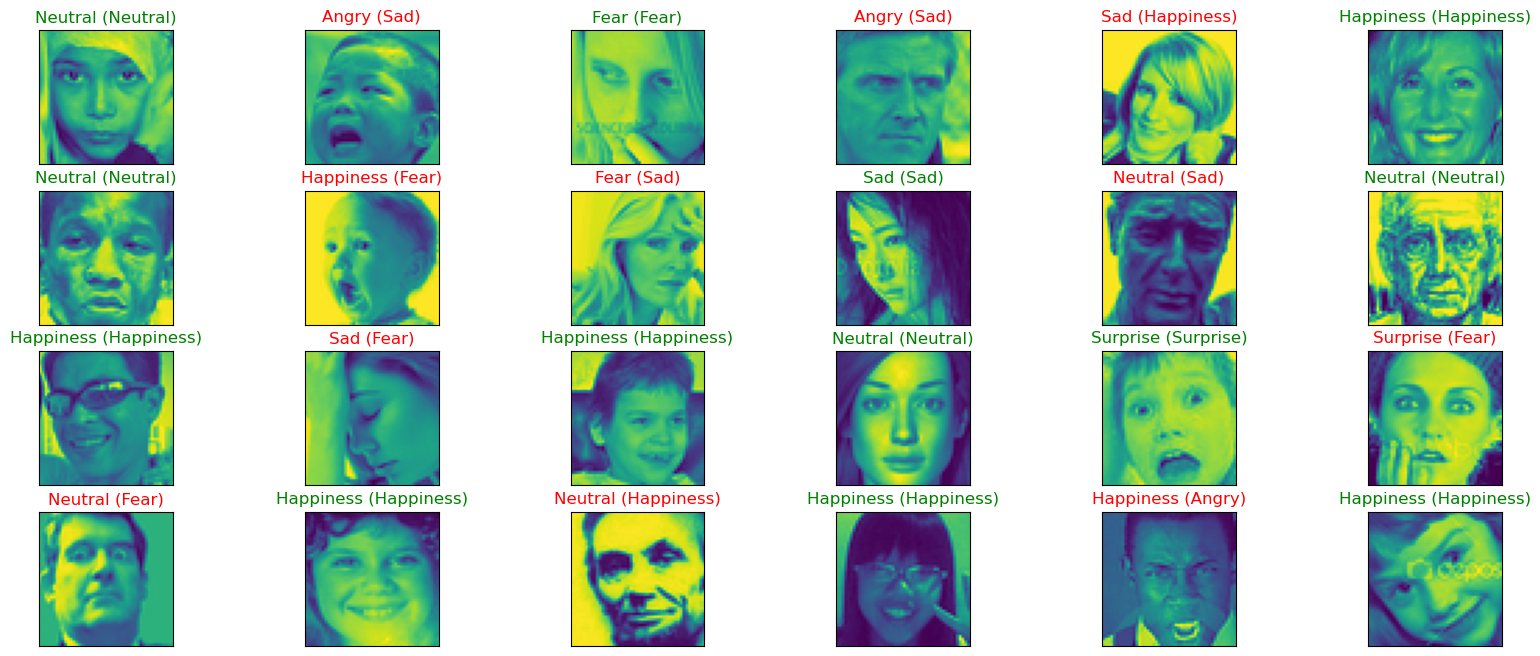

In [51]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [52]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [53]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.439     0.584     0.501       478
           1      0.576     0.275     0.373        69
           2      0.427     0.218     0.289       523
           3      0.822     0.800     0.811       913
           4      0.450     0.418     0.434       605
           5      0.682     0.791     0.733       421
           6      0.485     0.598     0.536       580

    accuracy                          0.578      3589
   macro avg      0.554     0.526     0.525      3589
weighted avg      0.575     0.578     0.568      3589



Optimising

In [54]:
model = cnn_model()

In [55]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [56]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=checkpointer,
                    validation_data=val_generator)

Epoch 1/30
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1595 - loss: 3.5017
Epoch 1: val_accuracy did not improve from 0.57864
909/909 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.1595 - loss: 3.5015 - val_accuracy: 0.1542 - val_loss: 3.1439
Epoch 2/30
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1798 - loss: 3.1035
Epoch 2: val_accuracy did not improve from 0.57864
909/909 ━━━━━━━━━━━━━━━━━━━━ 52s 57ms/step - accuracy: 0.1798 - loss: 3.1035 - val_accuracy: 0.2260 - val_loss: 2.9395
Epoch 3/30
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1898 - loss: 2.9287
Epoch 3: val_accuracy did not improve from 0.57864
909/909 ━━━━━━━━━━━━━━━━━━━━ 51s 56ms/step - accuracy: 0.1898 - loss: 2.9287 - val_accuracy: 0.2294 - val_loss: 2.8393
Epoch 4/30
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2039 - loss: 2.8232
Epoch 4: val_accuracy did not improve from 0.57864
909/909 ━━━━━━━━━━━━━━━━━━━━ 62s 68ms/step - accuracy: 0.2039 - loss: 2.8232 - val_accuracy

In [57]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1402 - loss: 3.2277
Test Acc: 0.14488714933395386


In [58]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

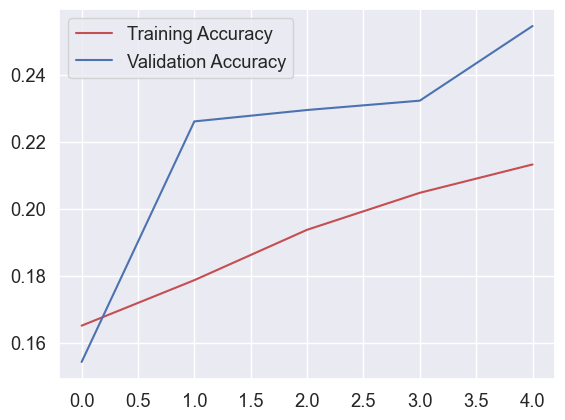

In [59]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

Changing number of Epochs

In [60]:
model = cnn_model()

In [61]:
model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [62]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.keras',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [63]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=1,
                    callbacks=checkpointer,
                    validation_data=val_generator)

Epoch 1/50
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1616 - loss: 3.3631
Epoch 1: val_accuracy improved from -inf to 0.24737, saving model to best_model.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 65s 62ms/step - accuracy: 0.1616 - loss: 3.3629 - val_accuracy: 0.2474 - val_loss: 2.5599
Epoch 2/50
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1904 - loss: 2.9360
Epoch 2: val_accuracy improved from 0.24737 to 0.26161, saving model to best_model.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step - accuracy: 0.1904 - loss: 2.9359 - val_accuracy: 0.2616 - val_loss: 2.4999
Epoch 3/50
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2060 - loss: 2.7762
Epoch 3: val_accuracy improved from 0.26161 to 0.26966, saving model to best_model.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 56s 61ms/step - accuracy: 0.2060 - loss: 2.7762 - val_accuracy: 0.2697 - val_loss: 2.4365
Epoch 4/50
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2265 - loss: 2.6501
Epoch 4: val_accuracy improved 

In [64]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6185 - loss: 1.1597
Test Acc: 0.6121482253074646


In [65]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


In [66]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [67]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))


              precision    recall  f1-score   support

           0      0.529     0.538     0.533       478
           1      0.737     0.203     0.318        69
           2      0.514     0.327     0.400       523
           3      0.858     0.805     0.831       913
           4      0.527     0.445     0.483       605
           5      0.628     0.860     0.726       421
           6      0.481     0.671     0.561       580

    accuracy                          0.612      3589
   macro avg      0.611     0.550     0.550      3589
weighted avg      0.618     0.612     0.604      3589



In [68]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

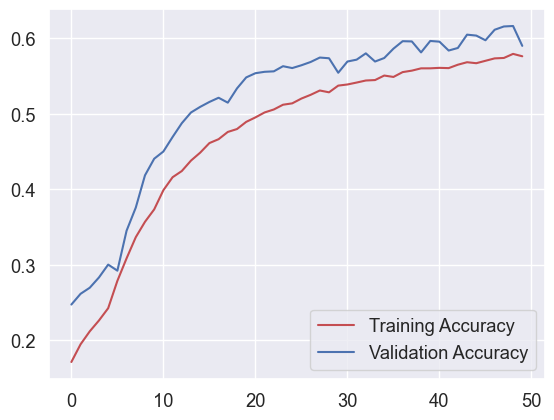

In [69]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

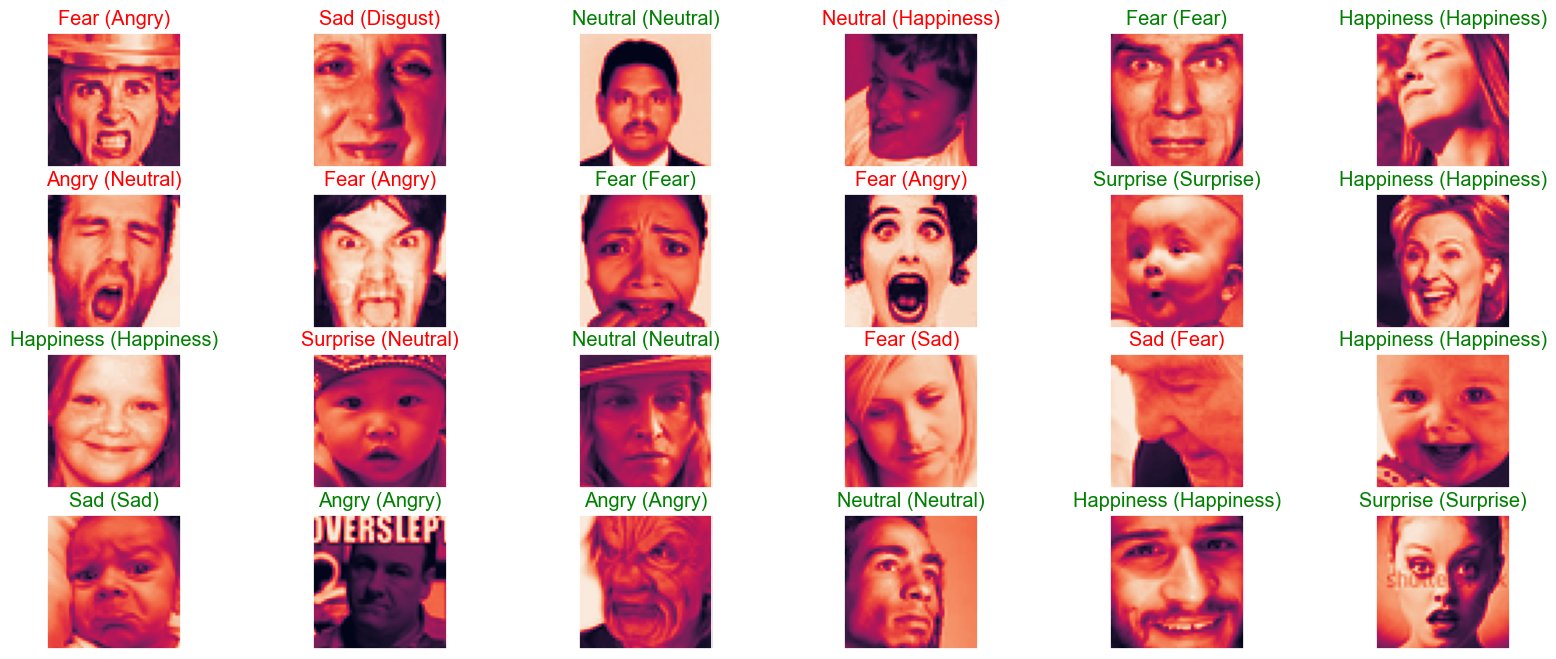

In [70]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [71]:
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [72]:
model.save('emotiondetection.keras')

In [83]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the saved model
model = load_model('best_model.keras')

# Define the label dictionary
label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Load and preprocess the image
image_path = r'C:\Users\dsilv\development\Emotion Detection\data\train\sad\Training_1362985.jpg'  # Replace with your image path
image = load_img(image_path, color_mode='grayscale', target_size=(48, 48))  # Resize to (48, 48)
image_array = img_to_array(image)  # Convert to NumPy array
image_array = image_array / 255.0  # Normalize pixel values
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Predict the emotion
predictions = model.predict(image_array)
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the highest probability
predicted_label = label_dict[predicted_class]  # Map index to emotion label

# Display the result
print(f"Predicted Emotion: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Predicted Emotion: Angry


In [84]:
# Display the probabilities for debugging
for i, prob in enumerate(predictions[0]):
    print(f"{label_dict[i]}: {prob:.4f}")

# Check if "Angry" is disproportionately high


Angry: 0.3872
Disgust: 0.0038
Fear: 0.1466
Happiness: 0.1414
Sad: 0.2879
Surprise: 0.0189
Neutral: 0.0143


In [79]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('best_model.keras')

# Define the list of emotions
label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

def preprocess_image(image):
    img = cv2.resize(image, (48, 48))  # Resize to model's expected input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert color
    img = img.astype('float32') / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch size dimension
    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
    return img


def predict_emotion(image_path):
    """
    This function takes an image path, preprocesses the image,
    and returns the predicted emotion.
    """
    # Load the image from the given path
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image could not be loaded from path: {image_path}")

    processed_image = preprocess_image(img)

    # Make prediction
    prediction = model.predict(processed_image)
    
    # Print prediction scores for debugging
    print(f"Prediction scores: {prediction}")

    # Get the index of the highest score
    predicted_index = np.argmax(prediction)

    # Map the index to the emotion
    predicted_emotion = label_dict[predicted_index]

    return predicted_emotion

# Example usage:
if __name__ == "__main__":
    image_path = r'C:\Users\dsilv\development\Emotion Detection\data\train\happy\Training_623077.jpg'
    predicted_emotion = predict_emotion(image_path)
    print(f'The predicted emotion is: {predicted_emotion}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Prediction scores: [[0.382485   0.0038314  0.14829226 0.14590818 0.28646955 0.01881285
  0.01420086]]
The predicted emotion is: Angry
